## WomenTechWomenYes project

### Goal
WomenTechWomenYes (WTWY), a fictitious organization, wishes to spread word of their annual gala (on May 30th 2017) by placing street teams in front of various New York MTA stations. The goal of the gala is to increase the participation of women in technology and extend their outreach. The street teams intend to interact with the crowd and get them to sign up for the gala.

The goal of this projects is to harness the power of data analytics and suggest the stations and timings for the street teams to be placed. 

### Data Resources
1. The GPS coordinates and the foot traffic (turnstile counts) for each MTA station was obtained from http://www.mta.info/.

1. Demographics of the neighborhoods near the stations was obtained from http://maps.nyc.gov/census.

1. Locations of the technology startups was obtained from http://www.digital.nyc/

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import dateutil
import pickle
import collections

%matplotlib inline

In [129]:
print('Pandas Version:', pd.__version__)
print('Numpy Version:', pd.__version__)

('Pandas Version:', u'0.18.1')
('Numpy Version:', u'0.18.1')


### Reading MTA turnstile data into a pandas DataFrame
As the gala is scheduled for 30th May, 2017, the canvassing of the MTA stations would take place in April and May, 2017. Hence, the analysis was done on data from April-May 2016.

In [ ]:
files_to_download = ['0402','0409','0416','0423','0430','0507','0514','0521','0528']
mta=[]

for item in files_to_download:
    mta.append(pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_16"+item+".txt"))

df = pd.concat(mta, ignore_index=True)

df.rename(columns=lambda x: x.strip(), inplace=True)
pickle.dump(df, open( "mta_raw.p", "wb" )) 

In [130]:
df = pickle.load( open("mta_raw.p", "rb"))

In [131]:
df.head(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456,BMT,03/26/2016,00:00:00,REGULAR,5595746,1893277
1,A002,R051,02-00-00,59 ST,NQR456,BMT,03/26/2016,04:00:00,REGULAR,5595746,1893282
2,A002,R051,02-00-00,59 ST,NQR456,BMT,03/26/2016,08:00:00,REGULAR,5595746,1893282
3,A002,R051,02-00-00,59 ST,NQR456,BMT,03/26/2016,12:00:00,REGULAR,5595746,1893282
4,A002,R051,02-00-00,59 ST,NQR456,BMT,03/26/2016,16:00:00,REGULAR,5595746,1893282


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1747550 entries, 0 to 1747549
Data columns (total 11 columns):
C/A         object
UNIT        object
SCP         object
STATION     object
LINENAME    object
DIVISION    object
DATE        object
TIME        object
DESC        object
ENTRIES     int64
EXITS       int64
dtypes: int64(2), object(9)
memory usage: 146.7+ MB


In [133]:
df.shape

(1747550, 11)

### Data Preprocessing
* The "date" and "time" columns are of type object. We don't want this, as this will prevent us from doing any kind of time series analysis. So, I converted them to pandas datetime objects.

In [134]:
df['date_time']=df['DATE']+" "+df['TIME']
df['date_time'] = pd.to_datetime(df['date_time'],format='%m/%d/%Y %H:%M:%S')
df['DATE'] = pd.to_datetime(df['DATE'],format='%m/%d/%Y')

* All turnstiles can be uniquely represented using C/A and SCP columns.   
I arrived at this conclusion by using a drop-out approach where I first group all rows using 'C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME' and 'DIVISION' and note the shape of the output. Subsequently, I dropped 1 column at a time and noted their shapes. We notice that all rows can be represented using a minimum of 2 columns, 'C/A' and 'SCP'.   

In [135]:
print(df.groupby(['C/A','UNIT','SCP','STATION','LINENAME','DIVISION','DATE'])[['C/A','UNIT','SCP','STATION','LINENAME','DIVISION','DATE']].count().shape)
print(df.groupby(['C/A','UNIT','SCP','STATION','LINENAME','DATE'])[['C/A','UNIT','SCP','STATION','LINENAME','DATE']].count().shape)
print(df.groupby(['C/A','UNIT','SCP','STATION','DATE'])[['C/A','UNIT','SCP','STATION','DATE']].count().shape)
print(df.groupby(['C/A','UNIT','SCP','DATE'])[['C/A','UNIT','SCP','DATE']].count().shape)
print(df.groupby(['C/A','UNIT','DATE'])[['C/A','UNIT','DATE']].count().shape)
print(df.groupby(['C/A','SCP','DATE'])[['C/A','SCP','DATE']].count().shape)
print(df.groupby(['SCP','DATE'])[['SCP','DATE']].count().shape)

(288331, 7)
(288331, 6)
(288331, 5)
(288331, 4)
(45699, 3)
(288331, 3)
(13524, 2)


In [136]:
df['Turnstile'] = df['C/A'] + ' ' + df['SCP']

* A particular station can have multiple lines. But the entrances to platforms for different lines with the same station name can be located on two ends of a street. Hence, a combination of Station name and Line names is required to identify a station platform.

In [137]:
df['STN-LINE'] = df['STATION'] + ' ' + df['LINENAME']

* The entry and exit counts for each turnstile are cumulated every 4 hours. Some turnstile cumulative totals decreased at certain times. This could be due to the turnstiles being reset. A few turnstiles would continually decrease over some periods of time for unknown reasons. These anomalous readings were discarded.

In [138]:
df_sorted = df.sort_values(['Turnstile', 'DATE'], ascending=[True, True])
df_sorted['Entries_next'] = df_sorted['ENTRIES'].shift(-1)
df_sorted['New_entries'] = df_sorted['Entries_next'] - df_sorted['ENTRIES']
df_sorted['Turnstile_next'] = df_sorted['Turnstile'].shift(-1)
df_sorted['Turnstile_not_same'] = df_sorted['Turnstile'] != df_sorted['Turnstile_next'] 
df_sorted = df_sorted.query('Turnstile_not_same == False') 

df_sorted.head(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,date_time,Turnstile,STN-LINE,Entries_next,New_entries,Turnstile_next,Turnstile_not_same
0,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-03-26,00:00:00,REGULAR,5595746,1893277,2016-03-26 00:00:00,A002 02-00-00,59 ST NQR456,5595746.0,0.0,A002 02-00-00,False
1,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-03-26,04:00:00,REGULAR,5595746,1893282,2016-03-26 04:00:00,A002 02-00-00,59 ST NQR456,5595746.0,0.0,A002 02-00-00,False
2,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-03-26,08:00:00,REGULAR,5595746,1893282,2016-03-26 08:00:00,A002 02-00-00,59 ST NQR456,5595746.0,0.0,A002 02-00-00,False
3,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-03-26,12:00:00,REGULAR,5595746,1893282,2016-03-26 12:00:00,A002 02-00-00,59 ST NQR456,5595746.0,0.0,A002 02-00-00,False
4,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-03-26,16:00:00,REGULAR,5595746,1893282,2016-03-26 16:00:00,A002 02-00-00,59 ST NQR456,5595746.0,0.0,A002 02-00-00,False


In [139]:
df_sorted['New_entries'].max()

1936970444.0

* The highest value in the new_entries columns is 1936970444.0. This suggests that approx. 1.9 billion people passed through a particular turnstile in a 4-hour window. This is not humanly possible and this is an erroneous reading.   


* Hence, an upper bound of 10,000 was used on new_entries, leaving commuter counts that are likely real and typical for each turnstile. 


* It was also noticed that readings with high New_entries had DESC = RECOVRAUD in general. The readings where DESC = RECOVRAUD were also removed.  



In [140]:
df_sorted = df_sorted.query("DESC == 'REGULAR'").query('New_entries > 0').query('New_entries <= 10000')

In [141]:
df_sorted.shape

(1473163, 18)

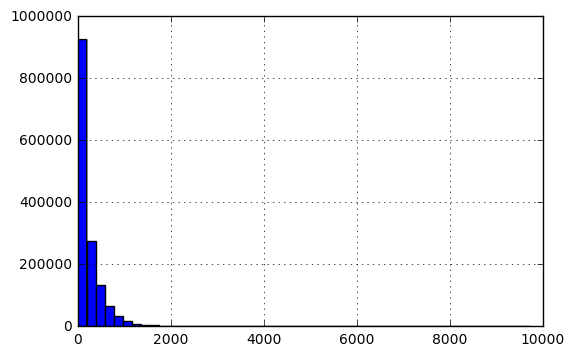

In [142]:
df_sorted['New_entries'].hist(bins=50);


In [143]:
pickle.dump(df_sorted, open( "mta_pre-processed.p", "wb" )) 

In [2]:
df_sorted = pickle.load( open("mta_pre-processed.p", "rb"))

### Top 20 stations with highest traffic

The table given below shows the top 20 stations with highest traffic in April-May 2016.

In [144]:
df_traffic = df_sorted.groupby(['STN-LINE','STATION','LINENAME'])[['New_entries']].sum().reset_index()
df_overall_traffic = df_traffic.sort_values(['New_entries'], ascending=[False])
top20 = df_overall_traffic.head(20)
top20

,STN-LINE,STATION,LINENAME,New_entries
309,GRD CNTRL-42 ST 4567S,GRD CNTRL-42 ST,4567S,8055527.0
90,34 ST-HERALD SQ BDFMNQR,34 ST-HERALD SQ,BDFMNQR,6690320.0
444,TIMES SQ-42 ST 1237ACENQRS,TIMES SQ-42 ST,1237ACENQRS,4806927.0
103,42 ST-PORT AUTH ACENQRS1237,42 ST-PORT AUTH,ACENQRS1237,4408901.0
94,34 ST-PENN STA ACE,34 ST-PENN STA,ACE,4402874.0
28,14 ST-UNION SQ LNQR456,14 ST-UNION SQ,LNQR456,4171359.0
156,86 ST 456,86 ST,456,3646972.0
286,FLUSHING-MAIN 7,FLUSHING-MAIN,7,3443972.0
124,59 ST COLUMBUS ABCD1,59 ST COLUMBUS,ABCD1,3341272.0
107,47-50 STS ROCK BDFM,47-50 STS ROCK,BDFM,3148665.0


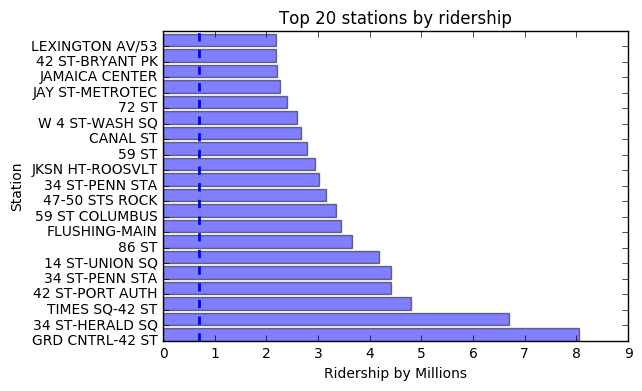

In [147]:
x_values = top20['New_entries']/1000000
y_values = top20['STATION']
y_position = np.arange(len(x_values))
plt.barh(y_position, x_values, alpha = 0.5);
plt.yticks(y_position, y_values);
plt.ylabel('Station');
plt.xlabel('Ridership by Millions');
plt.title('Top 20 stations by ridership')
plt.axvline(df_overall_traffic.New_entries.mean()/1000000, color='b', linestyle='dashed', linewidth=2);

The above graph shows us the ridership for top 20 stations with respect to the mean ridership of the other MTA stations.

### Finding stations near Tech Hubs

We want to be able to analyze stations within a region to target an audience.

However, the [turnstile data](http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description.txt) has Control Area (C/A) and Remote Unit while the [table of coordinates](http://web.mta.info/developers/data/nyct/subway/Stations.csv) has Stop ID.  We'll read in [table from 2013](https://docs.google.com/spreadsheets/d/10sz0xWODQ02Kemx6ovS0NLQ_gA0YV9YQtdD7uiCcyjI/edit?authkey=CMTzrvwE&hl=en&hl=en&authkey=CMTzrvwE#gid=2) that has Remote Unit and Station ID so we can correlate stations in our data sets with coordinates.  

In [148]:
rbs = pd.read_csv('Remote-Booth-Station2013.csv')
df_coords = pd.merge(df,rbs[['C/A','STOPID']],on='C/A')

In [149]:
coord = pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv')
coord = coord.rename(columns={'GTFS Stop ID': 'STOPID'})
df_coords = pd.merge(df_coords,coord[['STOPID','GTFS Latitude','GTFS Longitude']],on='STOPID')

In [150]:
df_coords[['GTFS Latitude','GTFS Longitude']].isnull().values.any()

False

### Silicon Alley
Northwest corner:
40.759721, -73.994992

Southeast corner:
40.735691, -73.975443

In [151]:
latitude = [40.735691, 40.759721]
longitude = [-73.994992, -73.975443]
silicon_alley = df_coords.copy()
silicon_alley['STN-LINE'] = df_coords['STATION']+' '+df_coords['LINENAME']
silicon_alley = silicon_alley[silicon_alley['GTFS Latitude']>latitude[0]]
silicon_alley = silicon_alley[silicon_alley['GTFS Latitude']<latitude[1]]
silicon_alley = silicon_alley[silicon_alley['GTFS Longitude']>longitude[0]]
silicon_alley = silicon_alley[silicon_alley['GTFS Longitude']<longitude[1]]

silicon_alley.groupby('STN-LINE').sum()

,ENTRIES,EXITS,GTFS Latitude,GTFS Longitude
STN-LINE,,,,
23 ST 6,1212260799979,1055129224906,397376.633456,-7.216653e+05
23 ST FM,1200446002045,1259073231477,156860.080300,-2.848724e+05
23 ST NR,55472744692,13011104158,216825.214566,-3.937713e+05
28 ST 1,12277380323,59686111101,169793.644905,-3.083304e+05
28 ST 6,570973706463,740760493368,268945.005070,-4.883701e+05
28 ST NR,10099767677,13089184781,140083.008372,-2.543731e+05
33 ST 6,133437750700,53110115796,342878.271615,-6.225592e+05
34 ST-HERALD SQ BDFMNQR,1228922372865,1304104574907,858593.376690,-1.558926e+06
34 ST-PENN STA 123,49985096009,39773679499,325106.475794,-5.903007e+05


In [152]:
silicon_alley_ranks = df_overall_traffic[df_overall_traffic['STN-LINE'].isin(silicon_alley['STN-LINE'])]
silicon_alley_ranks

,STN-LINE,STATION,LINENAME,New_entries
309,GRD CNTRL-42 ST 4567S,GRD CNTRL-42 ST,4567S,8055527.0
90,34 ST-HERALD SQ BDFMNQR,34 ST-HERALD SQ,BDFMNQR,6690320.0
444,TIMES SQ-42 ST 1237ACENQRS,TIMES SQ-42 ST,1237ACENQRS,4806927.0
103,42 ST-PORT AUTH ACENQRS1237,42 ST-PORT AUTH,ACENQRS1237,4408901.0
94,34 ST-PENN STA ACE,34 ST-PENN STA,ACE,4402874.0
107,47-50 STS ROCK BDFM,47-50 STS ROCK,BDFM,3148665.0
93,34 ST-PENN STA 123ACE,34 ST-PENN STA,123ACE,3014922.0
101,42 ST-BRYANT PK BDFM7,42 ST-BRYANT PK,BDFM7,2187120.0
92,34 ST-PENN STA 123,34 ST-PENN STA,123,1921869.0
88,33 ST 6,33 ST,6,1728387.0


## Lower Manhattan

Northwest Corner: 40.730034, -74.017021

Southeast Corner: 40.681435, -73.974389

In [153]:
latitude = [40.681435, 40.730034]
longitude = [-74.017021, -73.974389]
lower_man = df_coords.copy()
lower_man['STN-LINE'] = df_coords['STATION']+' '+df_coords['LINENAME']
lower_man = lower_man[lower_man['GTFS Latitude']>latitude[0]]
lower_man = lower_man[lower_man['GTFS Latitude']<latitude[1]]
lower_man = lower_man[lower_man['GTFS Longitude']>longitude[0]]
lower_man = lower_man[lower_man['GTFS Longitude']<longitude[1]]

lower_man.groupby('STN-LINE').sum()

,ENTRIES,EXITS,GTFS Latitude,GTFS Longitude
STN-LINE,,,,
2 AV F,39324604590,27962455701,154545.310590,-2.807918e+05
ATL AV-BARCLAY 2345BDNQR,45663028051,28841813263,350740.729660,-6.377548e+05
ATL AV-BARCLAY BDNQR2345,12081985613,14327934223,156143.910108,-2.839307e+05
B'WAY-LAFAYETTE BDFQ6,42034756026,34756761674,311222.719674,-5.654790e+05
BERGEN ST 23,5908371580,4992144462,125069.209730,-2.274479e+05
BLEECKER ST 6DF,10100273349,3771949026,139160.451555,-2.528397e+05
BOROUGH HALL 2345R,48342269459,29612932023,347764.249574,-6.323185e+05
BOROUGH HALL R2345,41469500463,2754838014,77683.355071,-1.412469e+05
BOWERY JZ,4843340854,5032544679,47154.084240,-8.568495e+04


In [154]:
lower_man_ranks = df_overall_traffic[df_overall_traffic['STN-LINE'].isin(lower_man['STN-LINE'])]
lower_man_ranks

,STN-LINE,STATION,LINENAME,New_entries
232,CANAL ST JNQRZ6,CANAL ST,JNQRZ6,2670409.0
332,JAY ST-METROTEC ACF,JAY ST-METROTEC,ACF,2263247.0
299,FULTON ST 2345ACJZ,FULTON ST,2345ACJZ,2183382.0
241,CHAMBERS ST ACE23,CHAMBERS ST,ACE23,2046685.0
211,BOROUGH HALL 2345R,BOROUGH HALL,2345R,1939925.0
300,FULTON ST ACJZ2345,FULTON ST,ACJZ2345,1865205.0
215,BOWLING GREEN 45,BOWLING GREEN,45,1677744.0
267,DELANCEY/ESSEX FJMZ,DELANCEY/ESSEX,FJMZ,1545970.0
459,WALL ST 23,WALL ST,23,1373351.0
305,GRAND ST BD,GRAND ST,BD,1372161.0


### Demographics

The demographics information (includes sex-ratio, educational information (highest degree attained) and professions) were then collected for the top 15 stations from Silicon Alley and Lower Manhattan. Now this information is combined with with the traffic and location information to find the stations with the targeted demographics.

In [155]:
demographics = pd.read_csv('Demographics.csv')
demographics.drop(['Unnamed: 0'],axis=1,inplace=True)

demographics.head(5)

,Female,Bachelors,Grad,Professional,STN-LINE
0,0.513,0.389,0.377,0.243,34 ST-PENN STA 123ACE
1,0.501,0.426,0.326,0.254,CANAL ST JNQRZ6W
2,0.520,0.400,0.358,0.238,33 ST 6
3,0.523,0.422,0.342,0.245,23 ST 6
4,0.501,0.426,0.326,0.254,BOWLING GREEN 45


In [156]:
new_ranked = pd.merge(df_overall_traffic,demographics,on='STN-LINE')
new_ranked['Female_Ct'] = new_ranked['New_entries']*new_ranked['Female']
new_ranked['Bachelors_Ct'] = new_ranked['New_entries']*new_ranked['Bachelors']
new_ranked['Grad_Ct'] = new_ranked['New_entries']*new_ranked['Grad']
new_ranked['Professional_Ct'] = new_ranked['New_entries']*new_ranked['Professional']
prof_ord = new_ranked.sort_values(['Professional_Ct'], ascending=False).index[:20]
grad_ord = new_ranked.sort_values(['Grad_Ct'], ascending=False).index[:20]
fem_ord = new_ranked.sort_values(['Female_Ct'], ascending=False).index[:20]
bach_ord = new_ranked.sort_values(['Bachelors_Ct'], ascending=False).index[:20]

new_ranked['Weighted_all'] = new_ranked['New_entries']*new_ranked['Female']* \
    (new_ranked['Bachelors']+new_ranked['Grad'])*new_ranked['Professional']
all_ord = new_ranked.sort_values(['Weighted_all'], ascending=False).index[:20]

In [160]:
top = new_ranked.iloc[0:11]
new_top = new_ranked.iloc[all_ord[0:11]]
new_top = new_top.drop(['LINENAME','STATION'],axis=1)
new_top

,STN-LINE,New_entries,Female,Bachelors,Grad,Professional,Female_Ct,Bachelors_Ct,Grad_Ct,Professional_Ct,Weighted_all
0,GRD CNTRL-42 ST 4567S,8055527.0,0.553,0.428,0.383,0.250,4454706.431,3447765.556,3085266.841,2013881.750,903191.728885
2,86 ST 456,3646972.0,0.559,0.468,0.372,0.242,2038657.348,1706782.896,1356673.584,882567.224,414418.265701
1,34 ST-PENN STA ACE,4402874.0,0.505,0.390,0.367,0.243,2223451.370,1717120.860,1615854.758,1069898.382,409006.102963
5,47-50 STS ROCK BDFM,3148665.0,0.520,0.387,0.387,0.243,1637305.800,1218533.355,1218533.355,765125.595,307947.749476
4,59 ST COLUMBUS ABCD1,3341272.0,0.515,0.334,0.481,0.216,1720755.080,1115984.848,1607151.832,721714.752,302921.724283
6,34 ST-PENN STA 123ACE,3014922.0,0.513,0.389,0.377,0.243,1546654.986,1172804.658,1136625.594,732626.046,287891.265784
8,W 4 ST-WASH SQ ABCDEFM,2600156.0,0.503,0.448,0.390,0.250,1307878.468,1164869.888,1014060.840,650039.000,274000.539046
12,FULTON ST 2345ACJZ,2183382.0,0.516,0.440,0.380,0.279,1126625.112,960688.080,829685.160,609163.578,257749.293123
11,LEXINGTON AV/53 EM6,2185257.0,0.553,0.428,0.383,0.250,1208447.121,935289.996,836953.431,546314.250,245012.653783
10,42 ST-BRYANT PK BDFM7,2187120.0,0.520,0.387,0.387,0.243,1137302.400,846415.440,846415.440,531470.160,213906.109997


In [161]:
print(top['Female_Ct'].sum())
print(new_top['Female_Ct'].sum())

20479840.157
19427173.301


In [162]:
print("Female change:",new_top['Female_Ct'].sum()/top['Female_Ct'].sum())
print("Grad change:",new_top['Grad_Ct'].sum()/top['Grad_Ct'].sum())
print("Bach change:",new_top['Bachelors_Ct'].sum()/top['Bachelors_Ct'].sum())
print("Prof change:",new_top['Professional_Ct'].sum()/top['Professional_Ct'].sum())

('Female change:', 0.9485998500022376)
('Grad change:', 1.0949866561473143)
('Bach change:', 1.0696168391733225)
('Prof change:', 1.0641854464267493)


In [163]:
new_top["STN-LINE"]

0      GRD CNTRL-42 ST 4567S
2                  86 ST 456
1         34 ST-PENN STA ACE
5        47-50 STS ROCK BDFM
4       59 ST COLUMBUS ABCD1
6      34 ST-PENN STA 123ACE
8     W 4 ST-WASH SQ ABCDEFM
12        FULTON ST 2345ACJZ
11       LEXINGTON AV/53 EM6
10     42 ST-BRYANT PK BDFM7
14         CHAMBERS ST ACE23
Name: STN-LINE, dtype: object

Many of the top stations stayed the same after the re-ranking, but some showed a large change due to a smaller number of target commuters. Typically the percentage of residents around the stations with Bachelors was in 30-40’s range, graduate degree percentages were also in the 30-40’s, and percentage of careers in professional and scientific industries in the 10-20’s.   But, as an example, Flushing-Main St. (Line 7) is in a neighborhood with residents having significantly fewer Bachelor degrees (17%), graduate degrees (8.1%), and careers in professional and scientific industries (9.1%). While Flushing-Main St. was the eight busiest station, it dropped to the 22nd top station of targeted commuters.

We compared our stations to the 10 stations with the most overall traffic.  
By going to the stations in our list, WTWY teams will see 9% fewer commuters, resulting in 5% fewer females.

However, these are targeted commuters, so you are projected to see:  
* 6% more people in technical professions (1-2% more females)
* 10% more people with graduate degrees (5% more females)  
This is will increase the efficacy of your street teams.

### Day and Time

Now that we have figured out the stations which the WTWY teams should be canvassing, we now have to find out when they should be out canvassing.

We found that consistently the weekdays showed much more traffic than weekends (as expected). To illustrate this, below is the average weekly traffic for 34 ST-Herald Sq (linename: 123ACE) in April/May 2016.

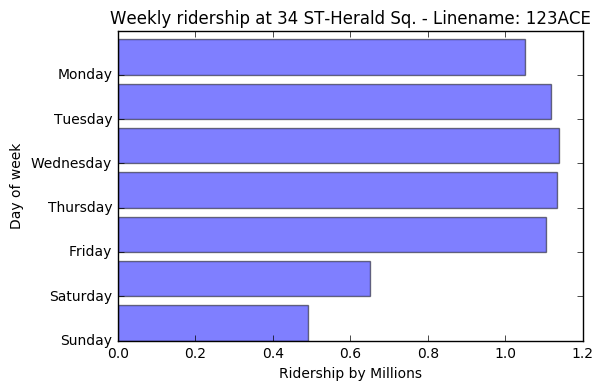

In [167]:
df_sorted['Weekday'] = df_sorted['DATE'].dt.weekday_name
df_sorted['Weekday_no'] = df_sorted['DATE'].dt.dayofweek
df_traffic = df_sorted.groupby(['STATION','LINENAME','Weekday','Weekday_no'])[['New_entries']].sum().reset_index()
df_overall_traffic = df_traffic.sort_values(['Weekday_no'], ascending=[False])
tt = df_overall_traffic[df_overall_traffic.STATION=="34 ST-HERALD SQ"]

x_values = tt['New_entries']/1000000
y_values = tt['Weekday']
y_position = np.arange(len(x_values))
plt.barh(y_position, x_values, alpha = 0.5);
plt.yticks(y_position, y_values);

plt.ylabel('Day of week');
plt.xlabel('Ridership by Millions');
plt.title("Weekly ridership at 34 ST-Herald Sq. - Linename: 123ACE")

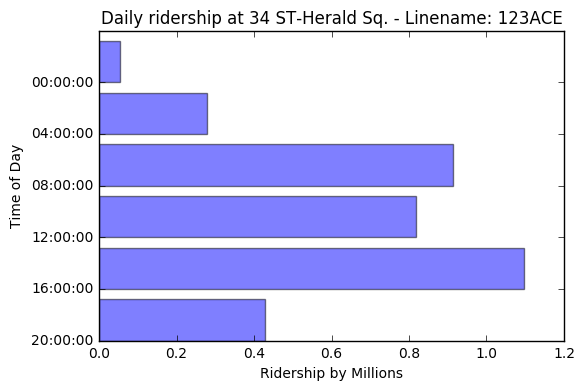

In [171]:
df_traffic = df_sorted.groupby(['STATION','LINENAME','TIME'])[['New_entries']].sum().reset_index()
df_overall_traffic = df_traffic.sort_values(['TIME'], ascending=[False])
tt = df_overall_traffic[df_overall_traffic.STATION=="86 ST"]
tt = tt[tt.LINENAME=='456']
tt = tt[tt.TIME.isin(['20:00:00','16:00:00','00:00:00','04:00:00','08:00:00','12:00:00'])]

x_values = tt['New_entries']/1000000
y_values = tt['TIME']
y_position = np.arange(len(x_values))
plt.barh(y_position, x_values, alpha = 0.5);
plt.yticks(y_position, y_values);

plt.ylabel('Time of Day');
plt.xlabel('Ridership by Millions');
plt.title("Daily ridership at 34 ST-Herald Sq. - Linename: 123ACE")

### Conclusion

By using commuter rates, demographic information, and location data for MTA subway stations, we were able to create a priority list of stations that would most likely have commuters who are famales with higher education degrees and careers in tech industries, as well as the academic community from top-tier universities. While these stations did show 9% less traffic, they actually resulted in an increase of 1-2% females in science/technical professions and 5% more females with graduate degrees. We were also able to identify optimal days and times for WTWY to be convassing for their gala.

With this information, we could create a canvassing schedule based on the availability of WTWY street teams and the number of days they are able to work. Based on the initial response received by the teams, we could further optimize the schedule.